## Credit Card Segmentation

objectives:
  - clusterize given customer credit card dataset
  - denote segments
  - extract useful insights
  - visualize data

#### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings # Ignores any warning
warnings.filterwarnings("ignore")

#### FUNCTIONS

In [6]:
def correlation_triangle_heatmap(data):
    '''
    Plot correlation triange heatmap.
    '''
    corrmat = data.corr()
    plt.figure(figsize=(40, 20))
    mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
    heatmap = sns.heatmap(corrmat, vmax=.8, annot=True, mask=mask)
    return heatmap

def violinplot(data):
    '''
    Plot a violin plot of the x: tenure, y: balance columns
    '''
    plt.figure(figsize=(9,7))
    ax = plt.axes() 
    sns.violinplot(x='tenure', y='balance', data=data, inner='quartile')
    plt.xlabel('Account Tenure')
    plt.ylabel('Account Balance')
    plt.title('Account Balance over Tenure')
    plt.show()
    
    
def elbowplot(data_scaled):
    '''
    Plot an elbow rule for choosing appropriate number of clusters.
    '''
    inertia = []
    for n_clusters in range(2, 14):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(data_scaled)
        inertia.append(kmeans.inertia_ / n_clusters)
        
    inertias = pd.DataFrame({'n_clusters': range(2, 14), 'inertia': inertia,})
    plt.figure(figsize=(10,8))
    plt.plot(inertias['n_clusters'], inertias['inertia'], marker='o', linestyle='--')
    plt.xlabel('Number of Clusters(k)')
    plt.ylabel('Average Within-Cluster Squared Distances')
        

#### EXPLORATORY DATA ANALYSIS

In [7]:
data = pd.read_csv('data/CC GENERAL.csv')
data.columns = data.columns.str.lower() # for convience lower columns' features

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

In [9]:
data.describe()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [10]:
# cust_id is irrelevant for clusterization problem so I'll drop it
data.drop('cust_id', axis=1, inplace=True)

#### HANDLING MISSING DATA

Note: First things first, so lets perform basic step of handling missing data.

In [11]:
# revealing missing values
data.isnull().sum().sort_values(ascending=False)

minimum_payments                    313
credit_limit                          1
balance                               0
cash_advance_frequency                0
prc_full_payment                      0
payments                              0
purchases_trx                         0
cash_advance_trx                      0
purchases_installments_frequency      0
balance_frequency                     0
oneoff_purchases_frequency            0
purchases_frequency                   0
cash_advance                          0
installments_purchases                0
oneoff_purchases                      0
purchases                             0
tenure                                0
dtype: int64

<AxesSubplot:>

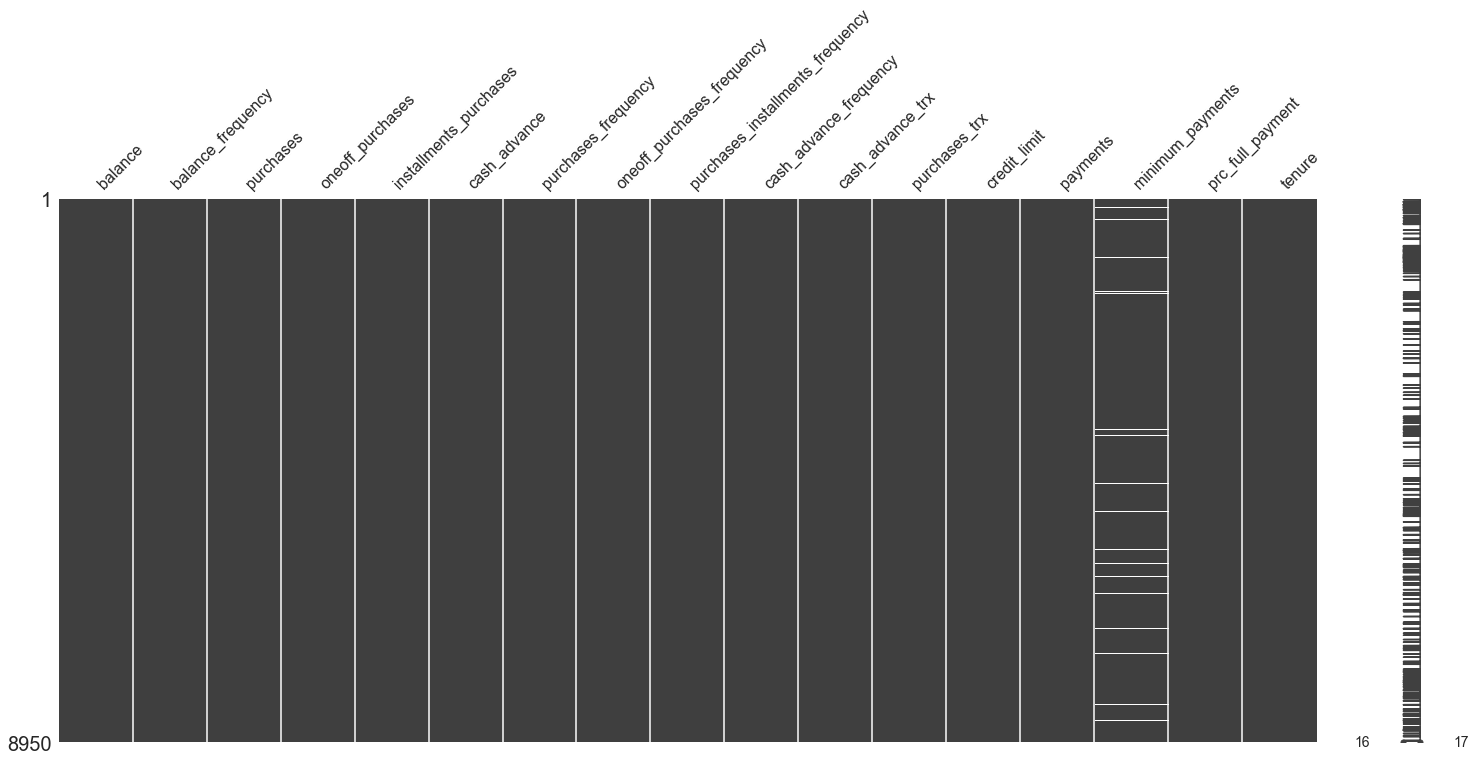

In [12]:
# explicit way to see missing values in a dataset
msno.matrix(data)

Note: exploring data skewness will help us decide how to treat missing values

In [13]:
data.skew().sort_values(ascending=False)

minimum_payments                    13.622797
oneoff_purchases                    10.045083
purchases                            8.144269
installments_purchases               7.299120
payments                             5.907620
cash_advance_trx                     5.721298
cash_advance                         5.166609
purchases_trx                        4.630655
balance                              2.393386
prc_full_payment                     1.942820
cash_advance_frequency               1.828686
oneoff_purchases_frequency           1.535613
credit_limit                         1.522464
purchases_installments_frequency     0.509201
purchases_frequency                  0.060164
balance_frequency                   -2.023266
tenure                              -2.943017
dtype: float64

<AxesSubplot:xlabel='minimum_payments', ylabel='Density'>

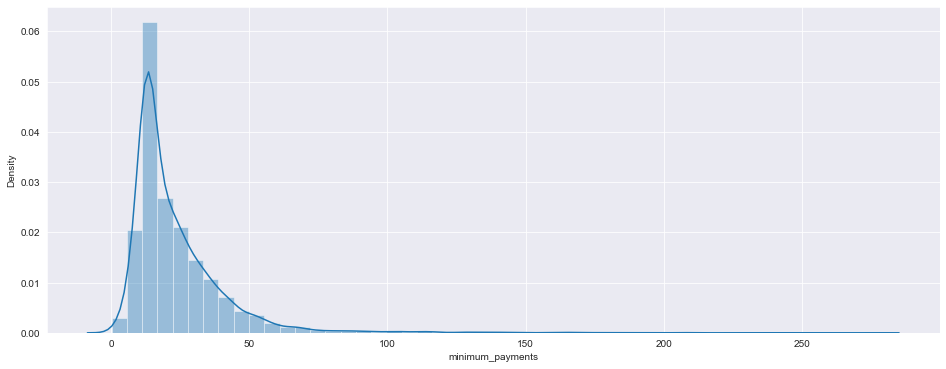

In [14]:
plt.figure(figsize = (16,6))
sns.distplot(np.sqrt(data['minimum_payments']))

In [15]:
data['credit_limit'].fillna(0, inplace=True)

# MINIMUM_PAYMENTS is skewed - fill NA vals. with medium value
col_min_payments = data['minimum_payments']
col_min_payments.fillna(col_min_payments.median(), inplace=True)

In [16]:
data.isnull().sum().sort_values(ascending=False)

balance                             0
cash_advance_frequency              0
prc_full_payment                    0
minimum_payments                    0
payments                            0
credit_limit                        0
purchases_trx                       0
cash_advance_trx                    0
purchases_installments_frequency    0
balance_frequency                   0
oneoff_purchases_frequency          0
purchases_frequency                 0
cash_advance                        0
installments_purchases              0
oneoff_purchases                    0
purchases                           0
tenure                              0
dtype: int64

#### HANDLING DUPLICATED VALUES

Note: checking for duplicates

In [50]:
data.duplicated().sum()

0

#### GETTING USEFUL INSIGHTS

In [18]:
o_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(exclude=['object']).columns.tolist()

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

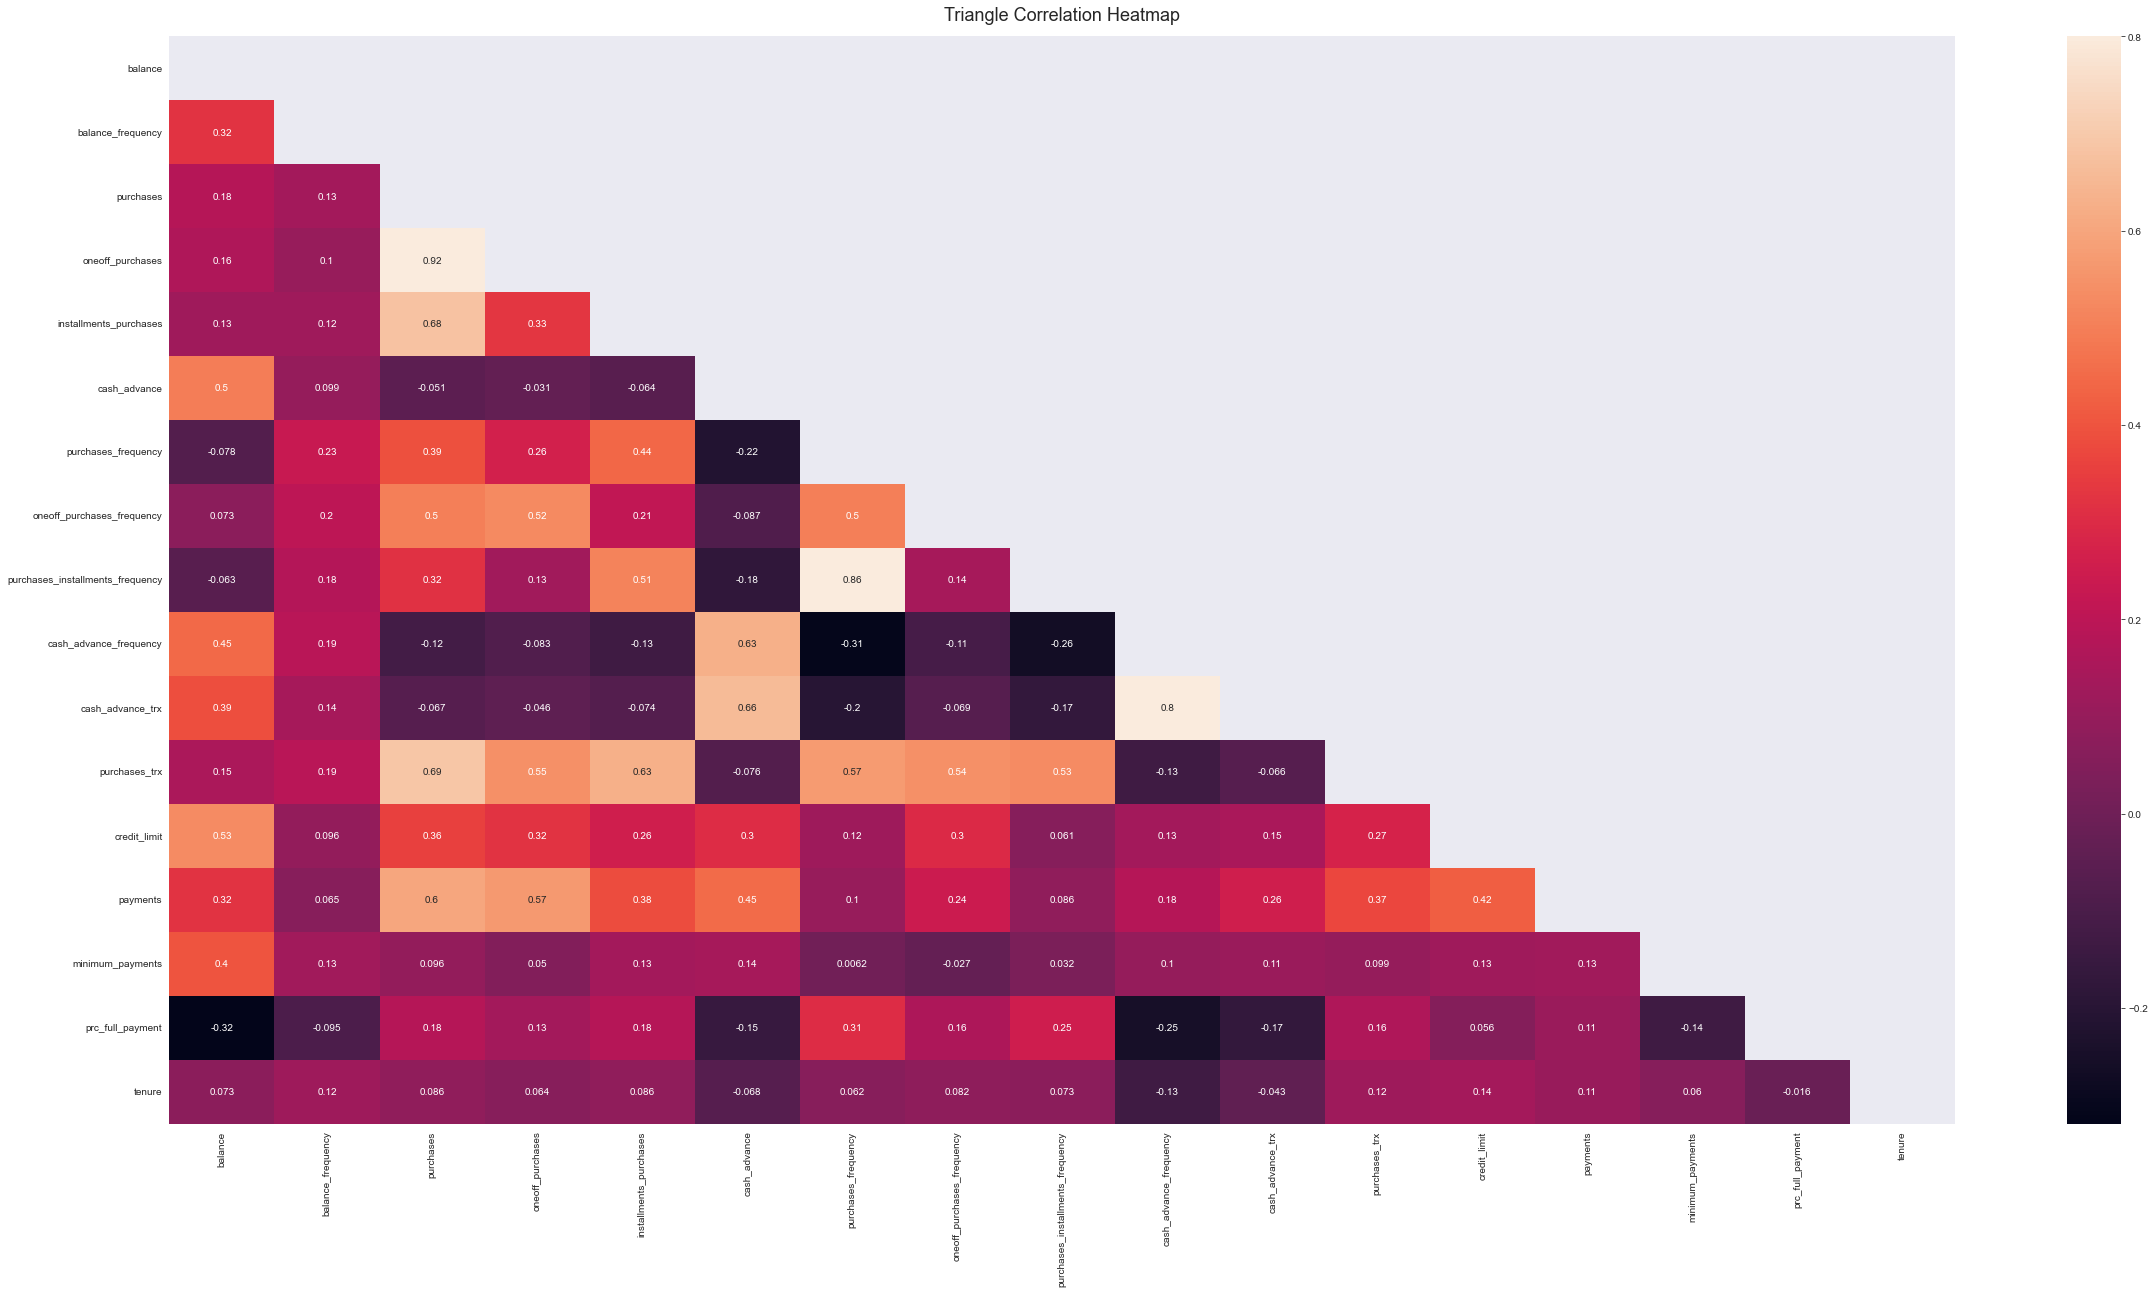

In [19]:
heatmap = correlation_triangle_heatmap(data)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

array([[<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'balance_frequency'}>,
        <AxesSubplot:title={'center':'purchases'}>,
        <AxesSubplot:title={'center':'oneoff_purchases'}>],
       [<AxesSubplot:title={'center':'installments_purchases'}>,
        <AxesSubplot:title={'center':'cash_advance'}>,
        <AxesSubplot:title={'center':'purchases_frequency'}>,
        <AxesSubplot:title={'center':'oneoff_purchases_frequency'}>],
       [<AxesSubplot:title={'center':'purchases_installments_frequency'}>,
        <AxesSubplot:title={'center':'cash_advance_frequency'}>,
        <AxesSubplot:title={'center':'cash_advance_trx'}>,
        <AxesSubplot:title={'center':'purchases_trx'}>],
       [<AxesSubplot:title={'center':'credit_limit'}>,
        <AxesSubplot:title={'center':'payments'}>,
        <AxesSubplot:title={'center':'minimum_payments'}>,
        <AxesSubplot:title={'center':'prc_full_payment'}>],
       [<AxesSubplot:title={'center':'tenure'

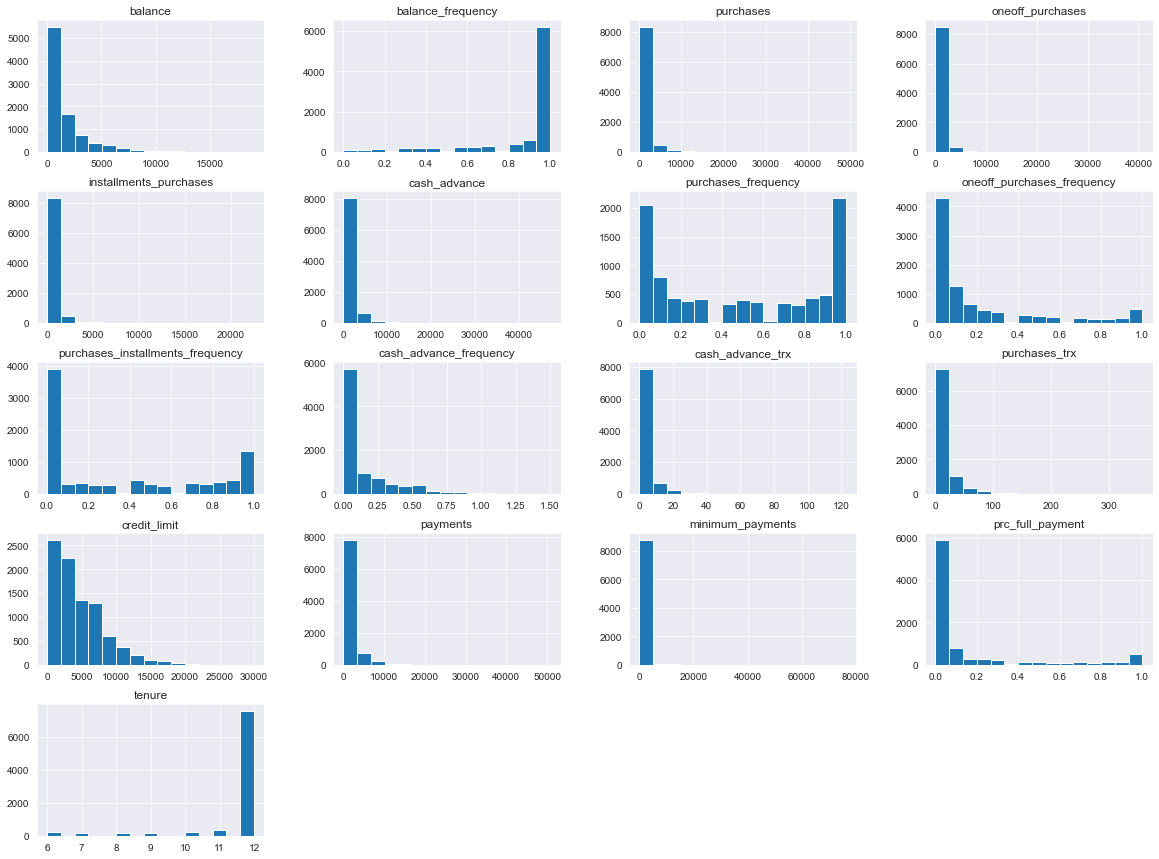

In [20]:
data[num_cols].hist(bins=15, figsize=(20, 15), layout=(5, 4))

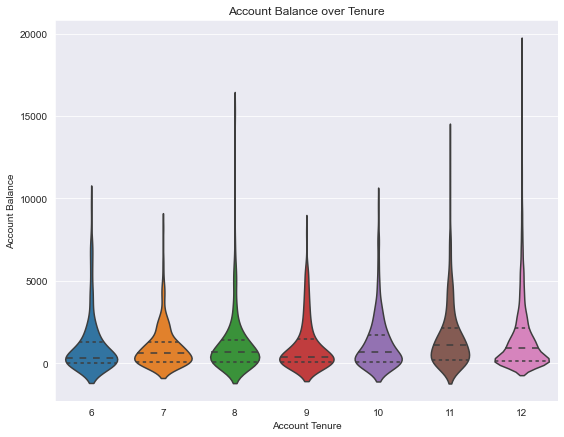

In [23]:
violinplot(data)

#### K-MEANS

##### STANDARDIZATION

Note: since clustering algorithms including kmeans use distance-based measurements to determine the similarity between data points, it’s recommended to standardize the data

In [24]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

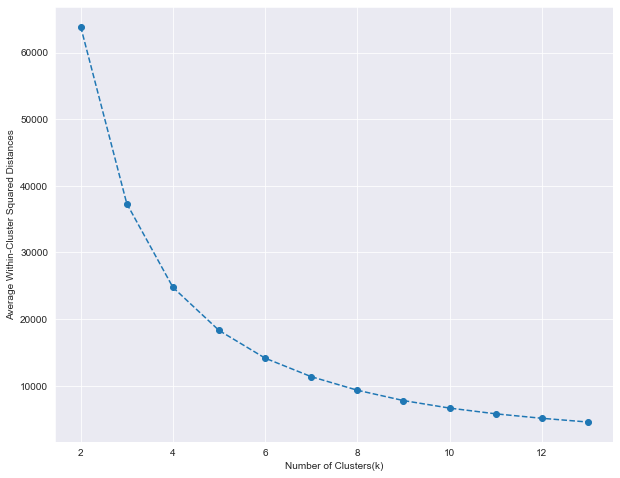

In [25]:
# performing elbow rule to choose number of clusters.
elbowplot(data_scaled)

In [26]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=4, random_state=42)

In [27]:
data_kmeans = data.copy()
data_kmeans['kmeans_cluster'] = kmeans.labels_

Note: here I will group by kmeans labels with a mean aggregation operation to manually capture some patterns and name clusters

In [28]:
data_kmeans_clust = data_kmeans.groupby('kmeans_cluster').mean()
data_kmeans_clust

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
kmeans_cluster,,,,,,,,,,,,,,,,,
0,3551.153761,0.986879,7681.620098,5095.878826,2587.208264,653.638891,0.946418,0.739031,0.788060,0.071290,2.085575,89.359413,9696.943765,7288.739497,1972.767288,0.286707,11.951100
1,1012.745945,0.789977,270.213240,210.016021,60.464108,597.051145,0.170249,0.086322,0.080642,0.114901,2.125943,2.907240,3277.439249,975.085151,553.868540,0.077983,11.446707
2,4602.449658,0.968389,501.862982,320.188797,181.759123,4521.509581,0.287832,0.138911,0.185671,0.484792,14.294904,7.665831,7546.160857,3484.054216,2003.674460,0.034888,11.386800
3,894.768927,0.934715,1236.263333,593.995933,642.541696,209.816318,0.885255,0.297109,0.711930,0.042487,0.789067,22.092692,4214.013741,1331.325429,639.740452,0.269313,11.594474


In [29]:
segments = {
  0: 'shopaholic',
  1: 'infrequent buyers',
  2: 'middle-ground',
  3: 'installment frequent buyers',
}

data_kmeans['cust_segment'] = data_kmeans['kmeans_cluster'].map(segments)
data_kmeans.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,kmeans_cluster,cust_segment
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1,infrequent buyers
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2,middle-ground
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3,installment frequent buyers
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,1,infrequent buyers
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1,infrequent buyers


#### EXPLANATORY DATA ANALYSIS

In [63]:
data_kmeans_segm = data_kmeans.groupby('cust_segment').mean()

Text(0.5, 1.0, 'Mean Balance per Segment')

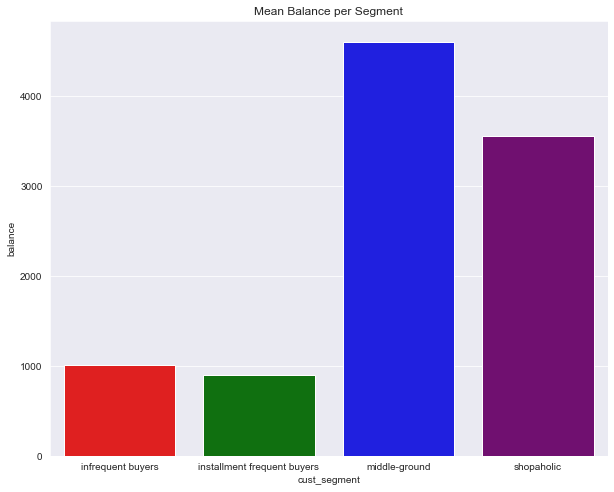

In [31]:
plt.figure(figsize=(10, 8))
sns.barplot(x=data_kmeans_segm.index, y=data_kmeans_segm['balance'], palette=['red', 'green', 'blue', 'purple'])
plt.title('Mean Balance per Segment')

Text(0.5, 1.0, 'Mean Purchases per Segment')

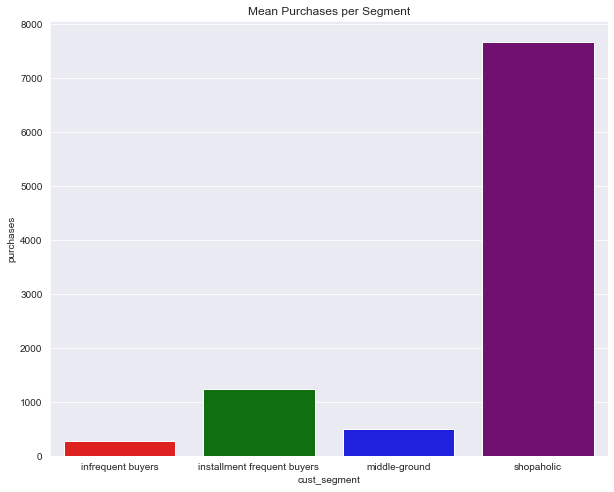

In [32]:
plt.figure(figsize=(10, 8))
sns.barplot(x=data_kmeans_segm.index, y=data_kmeans_segm['purchases'], palette=['red', 'green', 'blue', 'purple'])
plt.title('Mean Purchases per Segment')

Text(0.5, 1.0, 'Mean Purchases per Segment')

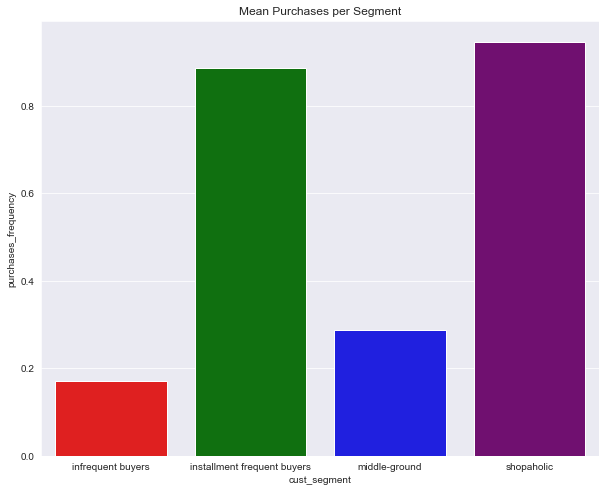

In [33]:
plt.figure(figsize=(10, 8))
sns.barplot(x=data_kmeans_segm.index, y=data_kmeans_segm['purchases_frequency'], palette=['red', 'green', 'blue', 'purple'])
plt.title('Mean Purchases per Segment')

In [30]:
observations_segm = data_kmeans.groupby('cust_segment').count().iloc[:, 0]
observations_segm

cust_segment
infrequent buyers              3978
installment frequent buyers    3366
middle-ground                  1197
shopaholic                      409
Name: balance, dtype: int64

In [34]:
data_kmeans_segm['observations'] = observations_segm.values
data_kmeans_segm

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,kmeans_cluster,observations
cust_segment,,,,,,,,,,,,,,,,,,,
infrequent buyers,1012.745945,0.789977,270.213240,210.016021,60.464108,597.051145,0.170249,0.086322,0.080642,0.114901,2.125943,2.907240,3277.439249,975.085151,553.868540,0.077983,11.446707,1.0,3978
installment frequent buyers,894.768927,0.934715,1236.263333,593.995933,642.541696,209.816318,0.885255,0.297109,0.711930,0.042487,0.789067,22.092692,4214.013741,1331.325429,639.740452,0.269313,11.594474,3.0,3366
middle-ground,4602.449658,0.968389,501.862982,320.188797,181.759123,4521.509581,0.287832,0.138911,0.185671,0.484792,14.294904,7.665831,7546.160857,3484.054216,2003.674460,0.034888,11.386800,2.0,1197
shopaholic,3551.153761,0.986879,7681.620098,5095.878826,2587.208264,653.638891,0.946418,0.739031,0.788060,0.071290,2.085575,89.359413,9696.943765,7288.739497,1972.767288,0.286707,11.951100,0.0,409


Text(0.5, 1.0, 'Observations per Segment')

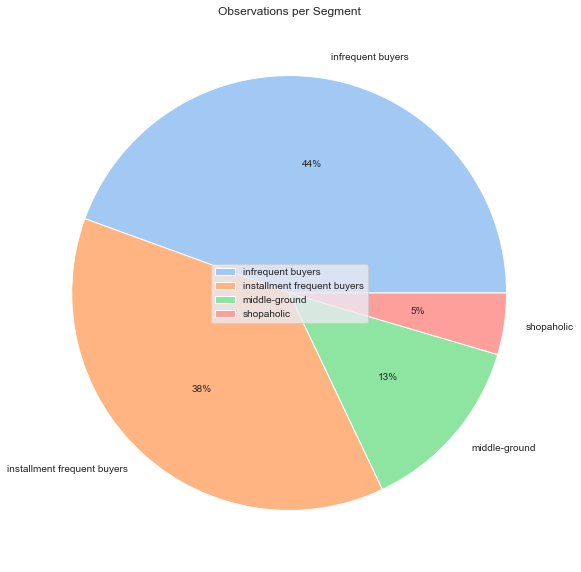

In [35]:
labels = data_kmeans_segm.index
colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(10, 10))
plt.pie(data_kmeans_segm['observations'], labels = labels, colors = colors, autopct='%.0f%%')

plt.legend(loc='center')
plt.ylabel(None, loc='center')
plt.title('Observations per Segment')

#### PCA

Note: it is a common practice to apply PCA, it improves the clustering results in practice (noise reduction)

In [36]:
pca = PCA()
pca.fit(data_scaled)

PCA()

Text(0.5, 0, 'Components')

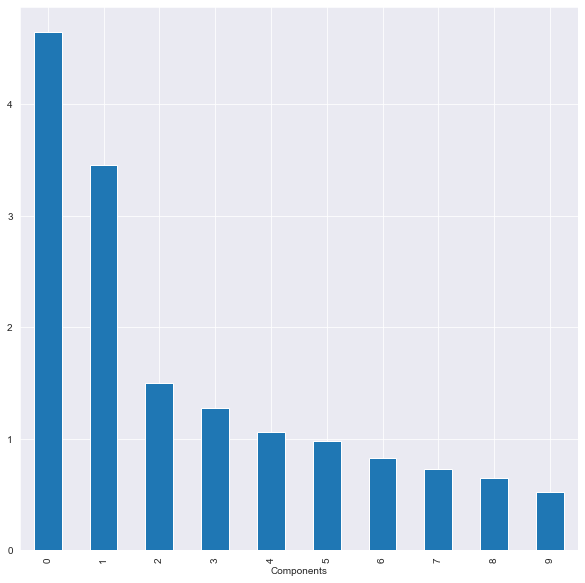

In [37]:
explained_variance = pd.DataFrame(pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(10, 10), )
ax.set_xlabel('Components')

Note: Setting threshold 80% of captured variance to choose number of principal components.

Text(0, 0.5, 'Captured Variance')

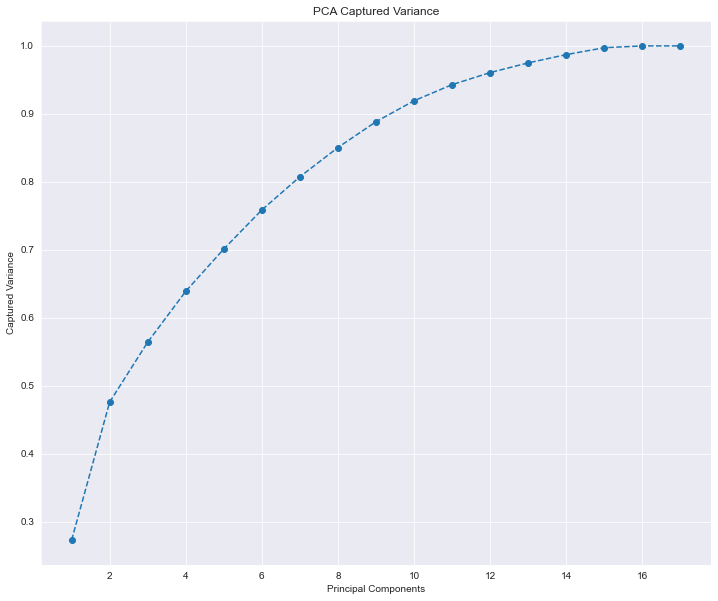

In [38]:
plt.figure(figsize=(12,10))
plt.plot(range(1, 18), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', )
plt.title('PCA Captured Variance')
plt.xlabel('Principal Components')
plt.ylabel('Captured Variance')

In [39]:
pca = PCA(n_components=7)
pca.fit(data_scaled)

PCA(n_components=7)

Note: plot loadings to define principal components

In [40]:
data_loadings = pd.DataFrame(pca.components_, columns=data.columns)
maxPC = 1.01 * np.max(np.max(np.abs(data_loadings)))

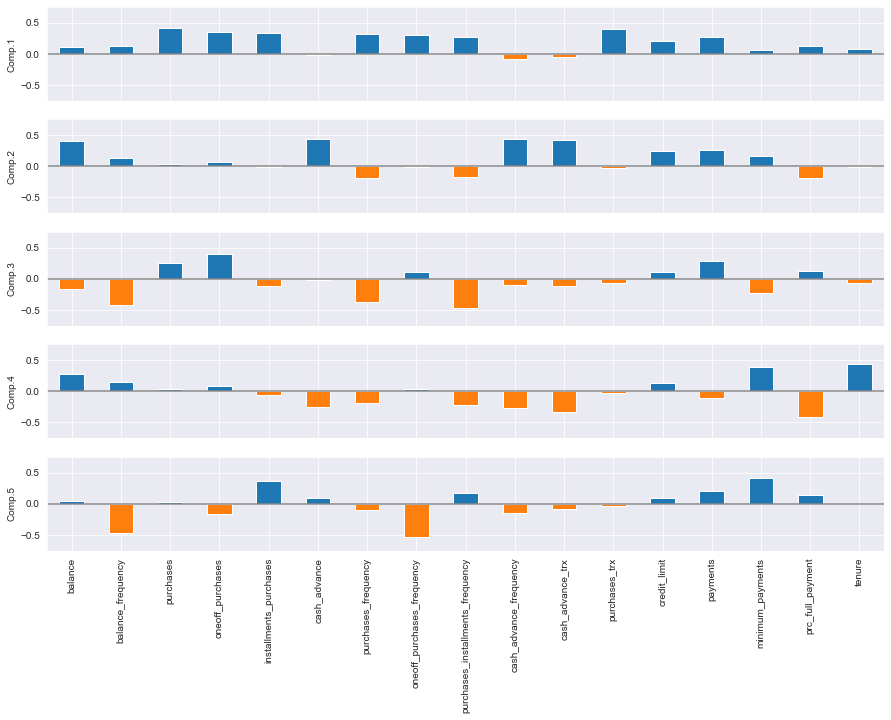

In [41]:
f, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes):
  pc_loadings = data_loadings.iloc[i, :]
  colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
  ax.axhline(color='#888888')
  pc_loadings.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Comp.{i+1}')
  ax.set_ylim(-maxPC, maxPC)

In [42]:
data_loadings.index = ['Comp. 1', 'Comp. 2', 'Comp. 3', 'Comp. 4', 'Comp. 5', 'Comp. 6', 'Comp. 7']

In [43]:
# dimensionality reduction

pca_scores = pca.transform(data_scaled)
pca_scores.shape

(8950, 7)

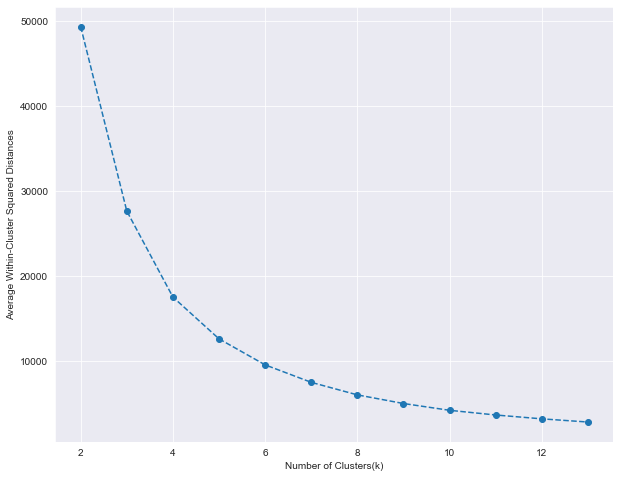

In [44]:
elbowplot(pca_scores) # elbow rule on low-dimensional dataset

In [45]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=241)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=4, random_state=241)

In [46]:
data_pca_kmeans = pd.concat([data, pd.DataFrame(pca_scores)], axis=1)
data_pca_kmeans.columns.values[-7:] = data_loadings.index.str.lower()

data_pca_kmeans['kmeans_cluster'] = kmeans_pca.labels_
data_pca_kmeans.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,...,prc_full_payment,tenure,comp. 1,comp. 2,comp. 3,comp. 4,comp. 5,comp. 6,comp. 7,kmeans_cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.000000,12,-1.683664,-1.072131,0.475767,0.679871,0.043519,0.068712,0.821987,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0.222222,12,-1.133957,2.509213,0.602155,-0.109193,0.662486,-1.102612,-0.384305,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,12,0.969437,-0.383575,0.090769,1.238657,-2.167116,-0.320474,-1.541093,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.000000,12,-0.888182,0.004667,1.499544,1.075546,0.225674,-0.171859,-0.235791,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.000000,12,-1.600014,-0.683671,0.348066,1.013580,-0.453494,0.077770,0.697987,1


#### DATA VISUALISATION

In [61]:
segments = {
  0: 'shopaholic',
  1: 'infrequent buyers',
  2: 'middle-ground',
  3: 'installment frequent buyers',
}

data_pca_kmeans['cust_segment'] = data_pca_kmeans['kmeans_cluster'].map(segments)
data_pca_kmeans.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,...,tenure,comp. 1,comp. 2,comp. 3,comp. 4,comp. 5,comp. 6,comp. 7,kmeans_cluster,cust_segment
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,12,-1.683664,-1.072131,0.475767,0.679871,0.043519,0.068712,0.821987,1,infrequent buyers
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,12,-1.133957,2.509213,0.602155,-0.109193,0.662486,-1.102612,-0.384305,2,middle-ground
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,12,0.969437,-0.383575,0.090769,1.238657,-2.167116,-0.320474,-1.541093,0,shopaholic
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,12,-0.888182,0.004667,1.499544,1.075546,0.225674,-0.171859,-0.235791,1,infrequent buyers
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,12,-1.600014,-0.683671,0.348066,1.013580,-0.453494,0.077770,0.697987,1,infrequent buyers


Text(0.5, 1.0, 'Customers')

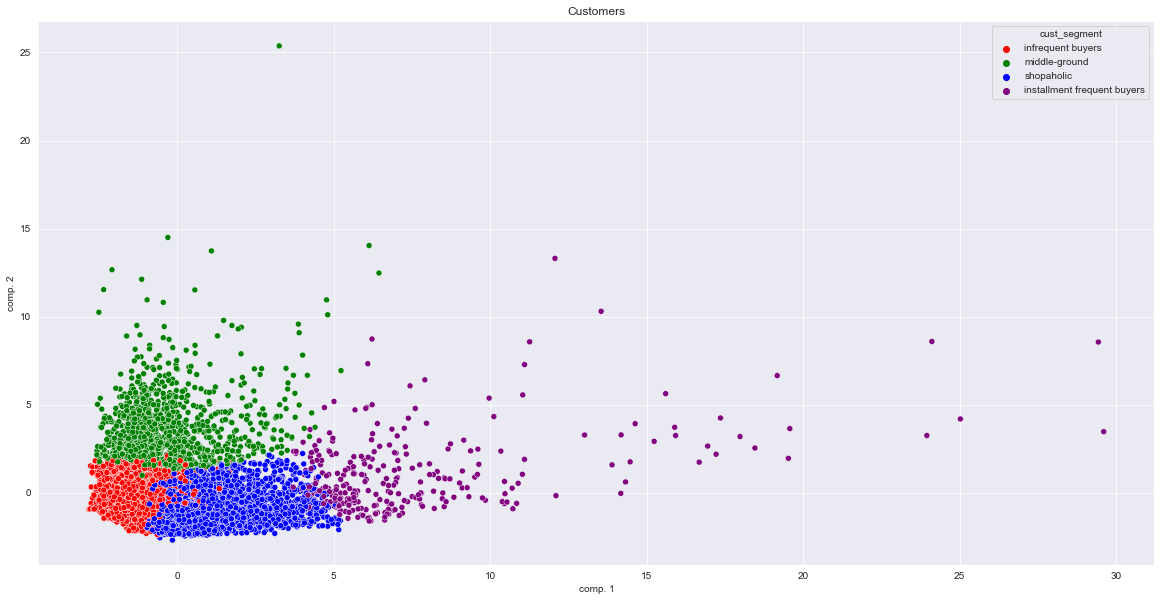

In [62]:
X = data_pca_kmeans['comp. 1']
Y = data_pca_kmeans['comp. 2']
hue = data_pca_kmeans['cust_segment']
plt.figure(figsize=(20, 10))
sns.scatterplot(X, Y, hue=hue, palette=['red', 'green', 'blue', 'purple'])
plt.title('Customers')